In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
import xlsxwriter 
%matplotlib inline
import import_ipynb
import functions_NGD
import random

importing Jupyter notebook from functions_NGD.ipynb


## Load data / find cross-correlation of ganglion cell output

In [2]:
# dt=0.01
# path_spike='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/'
# file_set=[['OU_tau=100ms_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=100ms_cutoff=10_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=100ms_cutoff=7_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=100ms_cutoff=4_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=100ms_cutoff=2_19-Apr-2020_0_sort_unit1.mat'],\
#     ['OU_tau=600ms_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=600ms_cutoff=10_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=600ms_cutoff=7_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=600ms_cutoff=4_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=600ms_cutoff=2_19-Apr-2020_0_sort_unit1.mat'],\
#     ['OU_tau=1000ms_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=1000ms_cutoff=10_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=1000ms_cutoff=7_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=1000ms_cutoff=4_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=1000ms_cutoff=2_19-Apr-2020_0_sort_unit1.mat']]

# # path_spike='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200318/'
# # file1='20200318_OU_tau=op5_fc=10_2_sort_unit1.mat'

# BinSpikes_set=[[[] for k in range(np.size(file_set,1))] for l in range(np.size(file_set,0))]
# sti_set=[[[] for k in range(np.size(file_set,1))] for l in range(np.size(file_set,0))]
# for i in range(np.size(file_set,0)):
#     for j in range(np.size(file_set,1)):
#         data1=loadmat(path_spike+file_set[i][j])
#         spikes=data1['Spikes'][0][38][0]
#         timestamp=data1['TimeStamps'][0]

#         adata1=data1['a_data'][0]
#         t=np.arange(1,len(adata1)+1e-5)/20000
#         sti=adata1[(t>timestamp[0]) & (t<timestamp[1])][0:-1:200]
#         sti=sti-np.mean(sti)
#         sti_set[i][j]=sti/np.std(sti)

#         spikes1=spikes[(spikes>timestamp[0]) & (spikes<timestamp[1])]-timestamp[0]
#         BinningTime=np.arange(0,timestamp[1]-timestamp[0],dt)
#         BinSpikes_set[i][j], bin_edges=np.histogram(spikes1,bins=BinningTime)
        
# x_set=sti_set

importing Jupyter notebook from NGDfunc.ipynb


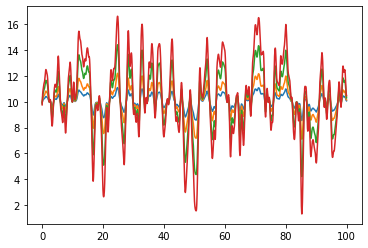

In [3]:
import os
os.chdir('F:/我的雲端硬碟/Retina exp/python code/functions')
import import_ipynb
import NGDfunc

dt=0.01
tau_ou=1
fc=1
T_ou=100
nsteps_ou=int(T_ou/dt)
mid_pos=500
randseed = np.random.normal(0, 50, nsteps_ou)
time_ou,x_ou=NGDfunc.OU(T_ou,tau_ou,'no',dt,randseed)
time_ou,x_lpou=NGDfunc.OU(T_ou,tau_ou,fc,dt,randseed)

amp=[0.5,1,2,3]
mean=10
x_set=[]
for i in range(len(amp)):
    x_set.append(x_lpou/np.std(x_lpou)*amp[i]+mean)
    plt.plot(time_ou,x_set[i])


## NGD output

In [3]:
alpha,beta,K,g=6,1.6,22,10 # channel 39
# alpha,beta,K,g=8,1.4,37,10 # channel 47
y_set=[[functions_NGD.NGD(x_set[i][j],dt,alpha,beta,K,g,1)[0] for j in range(np.size(x_set,1))] for i in range(np.size(x_set,0))]
z_set=[[functions_NGD.NGD(x_set[i][j],dt,alpha,beta,K,g,1)[1] for j in range(np.size(x_set,1))] for i in range(np.size(x_set,0))]

## Adding horizontal feedback to NGD output (y+z)

### MI and cross correlation of B

[0.8  0.85 0.9  0.95 1.  ]


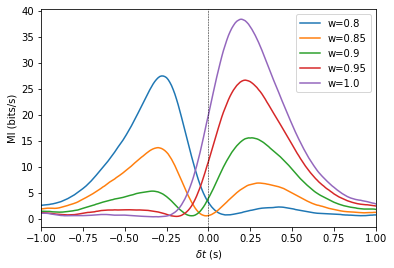

In [22]:
wy=np.linspace(0.8,1,5)
# wy=np.array([0.8,0.92])
print(wy)
# wy=[]
itau=1
ifc=4
x=x_set[itau][ifc]
y=y_set[itau][ifc]
z=z_set[itau][ifc]
B=[wy[k]*y-(1-wy[k])*z for k in range(len(wy))]
MIxyz=[[] for i in range(len(B))]
corrxyz=[[] for i in range(len(B))]
for k in range(len(B)):
    tsxyz,MIxyz[k]=functions_NGD.MI(functions_NGD.EqualState(x,8),functions_NGD.EqualState(B[k],8),dt,[-2,2])
    tc,corrxyz[k]=functions_NGD.xcorr_quick(x,B[k],5,0.01)
# color2=['k','r']
for i in range(len(B)):
    plt.plot(tsxyz,MIxyz[i],label='w='+str(round(wy[i],3)))
plt.legend()
plt.xlim(-1,1)
plt.ylabel('MI (bits/s)')
plt.xlabel('$\delta t$ (s)')
plt.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')
# plt.grid()
# find prediction horizon

# for i in range(len(MIxyz)):
#     plt.plot(tsxyz[np.argmax(MIxyz[i])],max(MIxyz[i]),'o')
# plt.show()

# plt.savefig('F:/我的雲端硬碟/Retina exp/Poster present/Sfn poster 20210111/figure/MI_fb_ff.png',dpi=300)

# for i in range(len(B)):
#     plt.plot(tc,corrxyz[i])
# plt.xlim(-5,5)
# plt.grid()

### generate poisson spikes

In [23]:
thr=0.6
SpikeTrains_Poisson=[[] for i in range(len(B))]
for i in range(len(B)):
    rtemp=B[i]-thr
    rtemp[rtemp>0]=0
    rtemp=rtemp/np.mean(rtemp)*5 # let the mean firing rate as 5 hz
    tempspikes=np.zeros(len(rtemp))
    for step in range(len(rtemp)):
        if random.random()<rtemp[step]*dt:
            tempspikes[step]=1
        else:
            tempspikes[step]=0
    SpikeTrains_Poisson[i]=tempspikes

(10000.0, 10500.0)

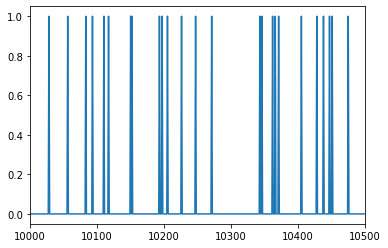

In [24]:
plt.plot(SpikeTrains_Poisson[1])
plt.xlim(10000,10500)

In [25]:
print(np.size(SpikeTrains_Poisson,0))

5


### calculate STA

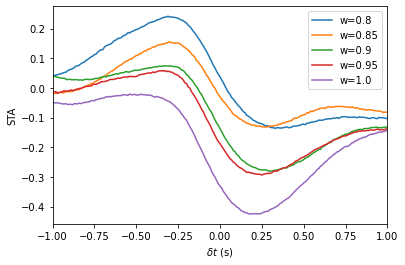

In [26]:
STAwindow=5
PoissonSTA_set=[[] for i in range(np.size(SpikeTrains_Poisson,0))]
for ii in range(np.size(SpikeTrains_Poisson,0)):
    sss=np.zeros(int(1+STAwindow/dt*2))
    n_spikes=0
    for i in range(len(SpikeTrains_Poisson[ii])):
        if SpikeTrains_Poisson[ii][i]>0:
            if (i-int(STAwindow/dt)>0) & (i+int(STAwindow/dt)<len(SpikeTrains_Poisson[ii])-1):
                n_spikes+=SpikeTrains_Poisson[ii][i]
                sss+=SpikeTrains_Poisson[ii][i]*x[i-int(STAwindow/dt):i+int(STAwindow/dt)+1]
    PoissonSTA_set[ii]=sss/n_spikes
t2s=np.arange(-5,5+1e-5,dt)

for j in range(np.size(SpikeTrains_Poisson,0)):
    plt.plot(t2s,PoissonSTA_set[j],label='w='+str(round(wy[j],3)))
plt.ylabel('STA')
plt.xlabel('$\delta t$ (s)')
plt.legend()
plt.xlim(-1,1)
plt.show()

In [ ]:
# STAwindow=5
# PoissonSTA_set=[[[] for i in range(np.size(x_set,1))] for j in range(np.size(x_set,0))]
# for ntau in range(np.size(x_set,0)):
#     for nfc in range(np.size(x_set,1)):
#         sss=np.zeros(int(1+STAwindow/dt*2))
#         n_spikes=0
#         for i in range(len(SpikeTrains_Poisson[ntau][nfc])):
#             if SpikeTrains_Poisson[ntau][nfc][i]>0:
#                 if (i-int(STAwindow/dt)>0) & (i+int(STAwindow/dt)<len(SpikeTrains_Poisson[ntau][nfc])-1):
#                     n_spikes+=SpikeTrains_Poisson[ntau][nfc][i]
#                     sss+=SpikeTrains_Poisson[ntau][nfc][i]*x_set[ntau][nfc][i-int(STAwindow/dt):i+int(STAwindow/dt)+1]
#         PoissonSTA_set[ntau][nfc]=sss/n_spikes
# t2s=np.arange(-5,5+1e-5,dt)

# for j in range(np.size(x_set,0)):
#     for i in range(np.size(x_set,1)):
#         plt.plot(t2s,PoissonSTA_set[j][i])
#     plt.xlim(-2,2)
#     plt.show()